# API for Minesweeper

Call the API to play Minesweeper

In [4]:
from scipy.ndimage import label
import sys
from api_http import MinesweeperAPI

import numpy as np

def parse_minesweeper_json_to_ndarray(resp_json):
    """
    Convert a Minesweeper JSON response to a 2D NumPy array of integer codes.
    
    :param resp_json: The JSON dict returned from /status or reveal/flag endpoints,
                      e.g. {
                          "rows": 9,
                          "cols": 9,
                          "game_over": false,
                          "board": [
                            [ { "covered": true, "flagged": false }, ... ],
                            ...
                          ]
                        }
    :return: A 2D NumPy array of shape (rows, cols), with integer codes representing cell states.
    """
    
    rows = resp_json["rows"]
    cols = resp_json["cols"]
    board_data = resp_json["board"]  # 2D list of cell objects
    result = np.zeros((rows, cols), dtype=np.int8)

    for r in range(rows):
        for c in range(cols):
            cell = board_data[r][c]
            
            if "covered" in cell:
                # Cell is not revealed
                if cell.get("flagged", False):
                    # Covered + flagged
                    result[r, c] = -1
                else:
                    # Covered (not flagged)
                    result[r, c] = 9
            elif "mine" in cell:
                # Uncovered mine
                result[r, c] = 10
            elif "adjacent" in cell:
                # Uncovered safe cell, store adjacent mine count (0..8)
                result[r, c] = cell["adjacent"]
            else:
                # Fallback if cell doesn't match any known pattern
                result[r, c] = 99

    return result

# Create an instance of the API
api = MinesweeperAPI('http://127.0.0.1:8000')
# Start a new game
def init_game():
    return api.init_board(4,4,4)

# Reveal a cell
def reveal_cell(row, col):
    return api.reveal_cell(row, col)

def get_board():
    return parse_minesweeper_json_to_ndarray(api.get_status())

def get_status():
    return api.get_status()['status']

# print(get_status())
# count time
init_game()
import time
# start = time.time()
# for ik in range(10):
    # api.get_status()
# end = time.time()
# print("Time: ", end - start)
# reveal_cell(0, 0)

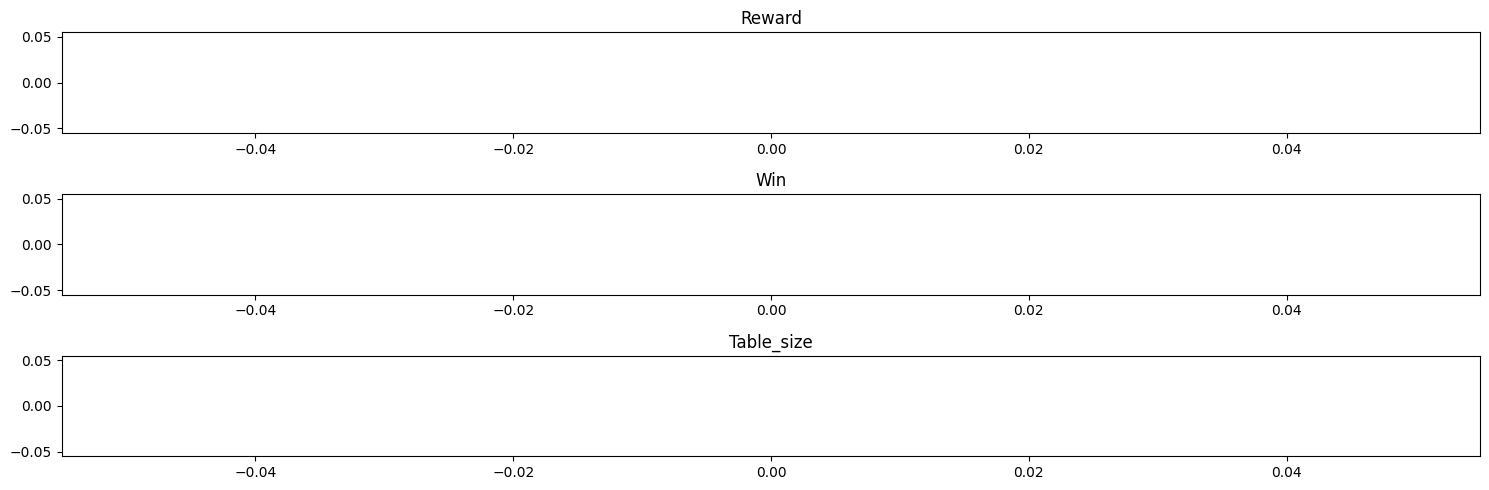

In [5]:
import multiprocessing
from multiprocessing import Manager, Lock
import numpy as np
import random
import matplotlib.pyplot as plt

learning_rate = 0.1
discount_factor = 0.9
exploration_rate = 1.0
exploration_rate_decay = 0.99
min_exploration_rate = 0.01
size = 4
board_size = size*size
def get_action(state, q_table, exploration_rate_=exploration_rate):
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if random.uniform(0, 1) < exploration_rate_:
        return random.randint(0, size-1)*size+ random.randint(0, size-1)
    else:
        return np.argmax(q_table[state])
    
def update_q_table(q_table, state, action, reward, next_state):
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if next_state not in q_table:
        q_table[next_state] = np.zeros(board_size)
    q_table[state][action] = q_table[state][action] + learning_rate * (reward + discount_factor * np.max(q_table[next_state]) - q_table[state][action])
    return q_table

def do_action(action,test=False):
    row = action // size
    col = action % size
    if test:
        return reveal_cell(row, col)
    return reveal_cell(row, col)[1]

def get_state():
    board = get_board()
    state = board.flatten()
    state = state.tolist()
    state = ''.join(map(str, state))
    return state

def get_reward(value):
    status = get_status()
    if status == 'win':
        return 1000
    elif status == 'lose':
        return -100
    elif value == 'invalid':
        return -100
    else:
        return 1

# Overwrite update_q_table
def update_q_table_parall(q_table, state, action, reward, next_state):
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if next_state not in q_table:
        q_table[next_state] = np.zeros(board_size)
    q_table[state][action] = q_table[state][action] + learning_rate * (
        reward + discount_factor * np.max(q_table[next_state]) - q_table[state][action]
    )
    return q_table

def get_action_parall(state, q_table, exploration_rate_):
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if random.uniform(0, 1) < exploration_rate_:
        return random.randint(0, size - 1) * size + random.randint(0, size - 1)
    else:
        return np.argmax(q_table[state])

def train_q_learning(q_table, epochs=1e4):
    count_win_ = 0
    avg_reward_ = 0
    exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_rate_decay = 0.9995
    learning_rate = 0.1
    discount_factor = 0.95
    for _ in range(int(epochs)):
        init_game()
        state = get_state()
        status = get_status()
        exploration_rate = max(exploration_rate * 
                               exploration_rate_decay, min_exploration_rate)
        sum_reward = 0
        while status == 'in_progress':
            action = get_action_parall(state, q_table, exploration_rate)
            value = do_action(action)
            next_state = get_state()
            reward = get_reward(value)
            if sum_reward == 0 and reward == -100:
                break
            sum_reward += reward
            q_table = update_q_table_parall(q_table, state, action, reward, next_state)
            state = next_state
            status = get_status()
        if status == 'win':
            count_win_ += 1
        avg_reward_ += sum_reward / epochs
    return q_table, count_win_*100/epochs, avg_reward_

def worker(q_table):
    if q_table is None:
        q_table = dict()
    q_table, count_win, avg_reward = train_q_learning(q_table)
    return q_table, count_win, avg_reward, len(q_table)

def merge_results(results):
    q_table = dict()
    win_list = []
    reward_list = []
    len_list = []
    for res in results:
        # merge q_table by select max value
        for key in res[0].keys():
            if key not in q_table:
                q_table[key] = res[0][key]
            else:
                q_table[key] = np.maximum(q_table[key], res[0][key])
        win_list.append(res[1])
        reward_list.append(res[2])
        len_list.append(res[3])
    return q_table, win_list, reward_list, len_list

def load_q():
    import pickle
    with open("q_table_.pkl", "rb") as tf:
        return pickle.load(tf)

def save_q(q_table):
    # Save the shared Q-table
    import pickle
    with open("q_table_.pkl", "wb") as tf:
        pickle.dump(dict(q_table), tf)  
        
import time
from IPython.display import clear_output

q_table_ = load_q()
# q_table_ = None
win_list_ = []
reward_list_ = []
len_list_ = []
eposide = 0
save_interval = 10
from multiprocessing import Pool
for i in range(eposide):
    start = time.time()
    with Pool(processes=2) as pool:
        results = pool.map(worker, [q_table_]*2)
    q_table_, win_list, reward_list, len_list = merge_results(results)
    win_list_.append(np.average(win_list))
    reward_list_.append(np.average(reward_list))
    len_list_.append(np.average(len_list))
    clear_output(wait=True)
    print(f"{i+1}/{eposide}", f"win:{np.average(win_list):.3f}%",f"reward:{np.average(reward_list):2}" , f"len:{np.average(len_list)}", f"time:{time.time()-start:.2f}")
    if (i+1)%save_interval == 0:
        save_q(q_table_)
        print("saved")


# Plot results
_, axes = plt.subplots(3, 1, figsize=(15, 5))
axes[0].plot(reward_list_)
axes[0].set_title('Reward')
axes[1].plot(win_list_)
axes[1].set_title('Win')
axes[2].plot(len_list_)
axes[2].set_title('Table_size')
plt.tight_layout()
plt.show()

In [6]:
# test 

def test_q_learning(epochs, q_table):
    count_win_ = 0
    for _ in range(int(epochs)):
        init_game()
        state = get_state()
        status = get_status()
        length = 0
        while status == 'in_progress':
            time.sleep(1)
            action = get_action(state, q_table, 0)
            do_action(action,test=True)
            next_state = get_state()
            state = next_state
            status = get_status()
            length+=1
            if length>25:
                break
        if status == 'win':
            count_win_ += 1
    return count_win_*100/epochs
print(test_q_learning(100,q_table_))

KeyboardInterrupt: 

In [42]:
# Q-learning agent
import numpy as np
import random
from tqdm import tqdm

learning_rate = 0.2
discount_factor = 0.98
exploration_rate = 1
exploration_rate_decay = 0.9995
min_exploration_rate = 0.01
is_win = 0
size = 5
board_size = size*size
def get_action(state, q_table, exploration_rate_=exploration_rate):
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if random.uniform(0, 1) < exploration_rate_:
        return random.randint(0, size-1)*size+ random.randint(0, size-1)
    else:
        return np.argmax(q_table[state])
    
def update_q_table(q_table, state, action, reward, next_state):
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if next_state not in q_table:
        q_table[next_state] = np.zeros(board_size)
    q_table[state][action] = q_table[state][action] + learning_rate * (reward + discount_factor * np.max(q_table[next_state]) - q_table[state][action])
    return q_table

def do_action(action):
    row = action // size
    col = action % size
    return reveal_cell(row, col)[1]

def get_state():
    board = get_board()
    state = board.flatten()
    state = state.tolist()
    state = ''.join(map(str, state))
    return state

def get_reward(value):
    status = get_status()
    if status == 'win':
        return 100
    elif status == 'lose':
        return -100
    elif value == 'invalid':
        return -1
    else:
        return 1

def train_q_learning(q_table=None, epochs=1e4):
    if q_table is None:
        q_table = dict()
    count_win_ = 0
    avg_reward_ = 0
    for i in tqdm(range(int(epochs))):
        init_game()
        state = get_state()
        status = get_status()
        global exploration_rate
        exploration_rate = max(exploration_rate * exploration_rate_decay, min_exploration_rate)
        sum_reward=0
        while status == 'in_progress':
            action = get_action(state, q_table)
            value = do_action(action)
            next_state = get_state()
            reward = get_reward(value)
            if sum_reward == 0 and reward == -100:
                break
            sum_reward+=reward
            q_table = update_q_table(q_table, state, action, reward, next_state)
            state = next_state
            status = get_status()
        if status == 'win':
            count_win_ += 1
        avg_reward_ += sum_reward / epochs
    return q_table, count_win_, avg_reward_ 
win_list = []
reward_list = []
q_table_=None
for i in range(10):
    exploration_rate = 1
    q_table_,count_win,avg_reward = train_q_learning(q_table_, 1e4)
    # print(f"epoch:{i}",count_win,avg_reward)
    win_list.append(count_win)
    reward_list.append(avg_reward)


import pickle
with open("q_table_.pkl", "wb") as tf:
    pickle.dump(q_table_,tf)


100%|██████████| 10000/10000 [00:07<00:00, 1260.88it/s][A

100%|██████████| 10000/10000 [00:08<00:00, 1226.03it/s][A

 58%|█████▊    | 5758/10000 [00:04<00:03, 1260.79it/s]


KeyboardInterrupt: 

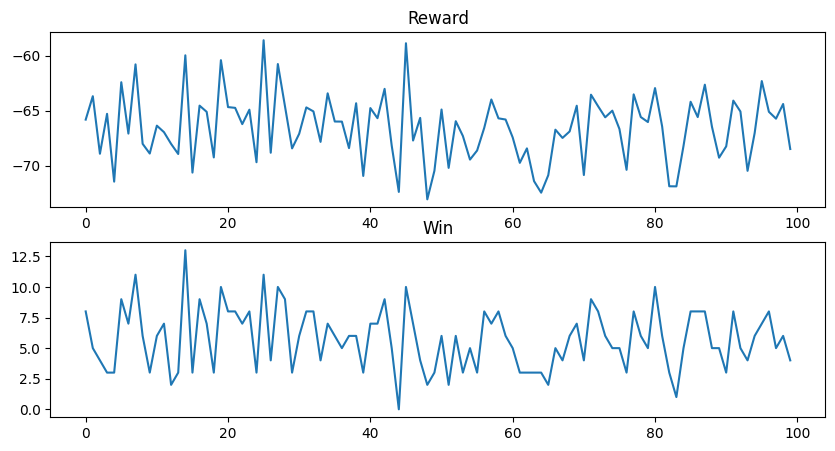

In [17]:
import matplotlib.pyplot as plt
_,axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(reward_list)
axes[0].set_title('Reward')
axes[1].plot(win_list)
axes[1].set_title('Win')

# save figure
plt.savefig('reward_win.png')


In [4]:
# save q_table_
import pickle

# with open("q_table_.pkl", "wb") as tf:
#     pickle.dump(q_table_,tf)

with open("q_table_.pkl", "rb") as tf:
    q_table_ = pickle.load(tf)

In [13]:
def test_q_learning():
    init_game()
    state = get_state()
    status = get_status()
    while status == 'in_progress':
        action = get_action(state, q_table_, exploration_rate_=0)
        do_action(action)
        state = get_state()
        status = get_status()
        print(state, action)
    print(status)
test_q_learning()

999999999999999999999999999999999999999999999999999999999999999999999999993999999 74
999999999999999999999999999999999999999999999999999999999999999999999999993999999 74
999999999999999999999999999999999999999999999999999999999999999999999999993999999 74
999999999999999999999999999999999999999999999999999999999999999999999999993999999 74


KeyboardInterrupt: 

In [ ]:
# multi-process
import multiprocessing
# lock
lock = multiprocessing.Lock()

# overwrite update_q_table
def update_q_table(q_table, state, action, reward, next_state):
    lock.acquire()
    if state not in q_table:
        q_table[state] = np.zeros(board_size)
    if next_state not in q_table:
        q_table[next_state] = np.zeros(board_size)
    q_table[state][action] = q_table[state][action] + learning_rate * (reward + discount_factor * np.max(q_table[next_state]) - q_table[state][action])
    lock.release()
    return q_table

def worker(q_table = q_table_, k=0):
    print("Worker ", k)
    for i in range(1):
        init_game()
        state = get_state()
        status = get_status()
        global exploration_rate
        exploration_rate = 1
        while status == 'in_progress':
            exploration_rate = exploration_rate * exploration_rate_decay
            exploration_rate = max(exploration_rate, min_exploration_rate)
            action = get_action(state, q_table)
            do_action(action)
            next_state = get_state()
            reward = get_reward()
            q_table = update_q_table(q_table, state, action, reward, next_state)
            state = next_state
            status = get_status()
            print(state, action, reward, next_state)
    
processes = []
for i in range(1):
    p = multiprocessing.Process(target=worker, args=(q_table_, i))
    p.start()
    processes.append(p)


In [5]:
# load 
import pickle
with open("q_table_.pkl", "rb") as tf:
    q_table_ = pickle.load(tf)

In [16]:
ret = int('9'*25)
len(q_table_)
print(pow(0.9995,1e4))

0.006729527022146667
